# Prediction of fire protection system failures based on sensor data

# Business Understanding 
With the help of the Inveron hazard management system, the plants already equipped with sensors can be 
be monitored and controlled manually, for example from a control station. 
from a control station. Inveron is a software that bundles and visualizes all sensor data from the 
fire protection systems and visualizes them. In addition, with the help of 
Inveron, test alarms can be triggered or alarms can be reset. 
The Inveron hazard management system already processes a lot of 
sensor data that can be used in the local system environment, for example the
security center of an industrial company. Specific
maintenance intervals tell Minimax service technicians when a system should be serviced. 
maintenance. 
In addition to monitoring its own sensor data, Inveron can also monitor third-party data. 
monitor. For example, connected video cameras can be used for fire detection. 
can be used for fire detection. Also burglar alarm systems, systems for 
fence monitoring or gate control systems. Open interfaces (OPC, 
Modbus, Profibus, BAC-net) allow long-term usability when individual components are 
exchange of individual components.


## 2.1. Import of Relevant Modules  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducability
np.random.seed(9876)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

## 2.2. load Data  

In [2]:
#load training data
train_df = pd.read_csv('https://storage.googleapis.com/ml-service-repository-datastorage/Prediction_of_IOT_system_failures_based_on_sensor_data_PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'zyklus', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']


In [3]:
# load testdata
test_df = pd.read_csv('https://storage.googleapis.com/ml-service-repository-datastorage/Prediction_of_IOT_system_failures_based_on_sensor_data_PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'zyklus', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']


In [4]:
# load truth data
truth_df = pd.read_csv('https://storage.googleapis.com/ml-service-repository-datastorage/Prediction_of_IOT_system_failures_based_on_sensor_data_PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

## 2.4. Descriptive Analytics  

In [5]:
def attribute_description(data):
    longestColumnName = len(max(np.array(data.columns), key=len))
    print("| Feature  | Data Type|")
    print("|-----|------|")
    for col in data.columns:
        description = ''
        col_dropna = data[col].dropna()
        example = col_dropna.sample(1).values[0]
        if type(example) == str:
            description = 'str '
            if len(col_dropna.unique()) < 10:
                description += '{'
                description += '; '.join([ f'"{name}"' for name in col_dropna.unique()])
                description += '}'
            else:
                description += '[ example: "'+ example + '" ]'
        elif (type(example) == np.int32) and (len(col_dropna.unique()) < 10) :
            description += 'dummy int32 {'
            description += '; '.join([ f'{name}' for name in sorted(col_dropna.unique())])
            description += '}'
        else:
            try:
                description = example.dtype
            except:
                 description = type(example)
        print("|" + col.ljust(longestColumnName)+ f'|   {description}  |')
 
attribute_description(train_df)

| Feature  | Data Type|
|-----|------|
|id      |   int64  |
|zyklus  |   int64  |
|setting1|   float64  |
|setting2|   float64  |
|setting3|   float64  |
|s1      |   float64  |
|s2      |   float64  |
|s3      |   float64  |
|s4      |   float64  |
|s5      |   float64  |
|s6      |   float64  |
|s7      |   float64  |
|s8      |   float64  |
|s9      |   float64  |
|s10     |   float64  |
|s11     |   float64  |
|s12     |   float64  |
|s13     |   float64  |
|s14     |   float64  |
|s15     |   float64  |
|s16     |   float64  |
|s17     |   int64  |
|s18     |   int64  |
|s19     |   float64  |
|s20     |   float64  |
|s21     |   float64  |


In [6]:
train_df = train_df.sort_values(['id','zyklus'])
train_df.head()


,id,zyklus,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


# 3. Data Preparation

## 3.1 check for null values

In [7]:
print(train_df.isna().sum())

id          0
zyklus      0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
dtype: int64


In [8]:
print(test_df.isna().sum())

id          0
zyklus      0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
dtype: int64


There are no Null values  
there is no missing data

## 2.1 calculate the remaining days until failure
Im ersten Schritt haben wir nun die Daten eingeladen und werden den Trainingsdatensatz nun mit einer weiteren Spalte versehen, nämlich der verbleibenden Zyklen bis zum Austausch des Feuermelders bzw. Bauteils. Im Testdatensatz wird eine weitere Spalten für die binäre Unterscheidung bzw. Klassifikation angelegt. Herauszufinden ist, ob ein spezifischer Feuermelder (ID) innerhalb w1-Zyklen ausfällt, weshalb hier für w1 ein fiktiver Wert von 1 gewählt wird (1 Tag).

In [9]:
remaining_days_until_F = pd.DataFrame(train_df.groupby('id')['zyklus'].max()).reset_index()
remaining_days_until_F.columns = ['id', 'max']
train_df = train_df.merge(remaining_days_until_F, on=['id'], how='left')
train_df['remaining_days_until_Failure'] = train_df['max'] - train_df['zyklus']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,zyklus,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,remaining_days_until_Failure
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [10]:
w1 = 20
w0 = 10
train_df['label1'] = np.where(train_df['remaining_days_until_Failure'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['remaining_days_until_Failure'] <= w0, 'label2'] = 2
train_df.head()


,id,zyklus,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,remaining_days_until_Failure,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


The cycle column "cycle" is to be normalized by means of a MinMax normalization, which is why a column with the normalized values is also created

In [11]:
train_df['Zyklus normalisiert'] = train_df['zyklus']
cols_normalize = train_df.columns.difference(['id','zyklus','remaining_days_until_Failure','label1','label2'])

minmax = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(minmax.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()


,id,zyklus,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,remaining_days_until_Failure,label1,label2,Zyklus normalisiert
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


Da nun eine Normalisierung der Trainingsdaten stattgefunden hat, wird für die Testdaten ebenfalls eine Normalisierung der Zyklen durchgeführt.

In [12]:
test_df['Zyklus normalisiert'] = test_df['zyklus']
norm_test_df = pd.DataFrame(minmax.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()


,id,zyklus,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,Zyklus normalisiert
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


Next, we use the truth data to generate the labels for the test data.

In [13]:
verbleibende_zyklen = pd.DataFrame(test_df.groupby('id')['zyklus'].max()).reset_index()
verbleibende_zyklen.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = verbleibende_zyklen['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)


In [14]:
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['remaining_days_until_Failure'] = test_df['max'] - test_df['zyklus']
test_df.drop('max', axis=1, inplace=True)
test_df.head()


,id,zyklus,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,Zyklus normalisiert,remaining_days_until_Failure
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


Next, we use the truth data to generate the labels for the test data.

In [15]:
test_df['label1'] = np.where(test_df['remaining_days_until_Failure'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['remaining_days_until_Failure'] <= w0, 'label2'] = 2
test_df.head()


,id,zyklus,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,Zyklus normalisiert,remaining_days_until_Failure,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


Now we look at the data structure

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 0 to 20630
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            20631 non-null  int64  
 1   zyklus                        20631 non-null  int64  
 2   setting1                      20631 non-null  float64
 3   setting2                      20631 non-null  float64
 4   setting3                      20631 non-null  float64
 5   s1                            20631 non-null  float64
 6   s2                            20631 non-null  float64
 7   s3                            20631 non-null  float64
 8   s4                            20631 non-null  float64
 9   s5                            20631 non-null  float64
 10  s6                            20631 non-null  float64
 11  s7                            20631 non-null  float64
 12  s8                            20631 non-null  float64
 13  s

It can be seen that all data have either the float or int data type, there are no categorical variables in the data set. Now we display the individual variables in a histogram in order to determine whether all variables can be used meaningfully for the model. The just created columns, as well as "id" are not considered, since these are used for the evaluation and it does not make sense to check here.


## 3.3 analyse the histogram's of all features

In [17]:
def plot_hist(variable):
    print("min {} : {} ".format(variable, min(train_df[variable])))
    print("max {} : {}".format(variable, max(train_df[variable])))
    
    plt.figure(figsize=(9,3))
    plt.hist(train_df[variable], color="orange", ec="orange", edgecolor='green')
    plt.xlabel(variable)
    plt.ylabel("Frequenz")
    plt.title("distribution of the {} variable ".format(variable))
    plt.show()

min zyklus : 1 
max zyklus : 362


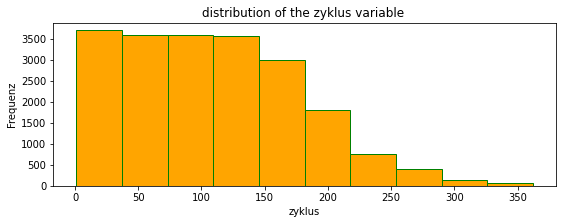

min setting1 : 0.0 
max setting1 : 1.0


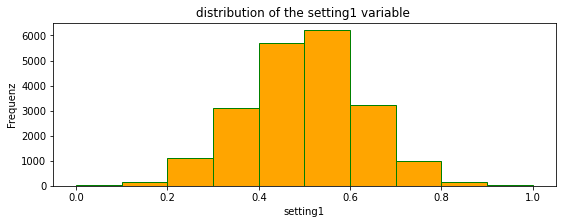

min setting2 : 0.0 
max setting2 : 1.0


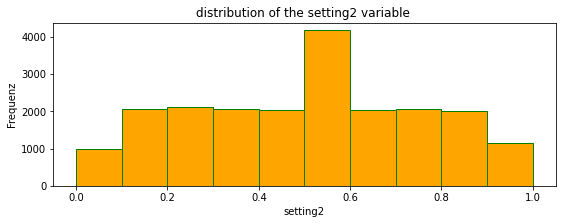

min setting3 : 0.0 
max setting3 : 0.0


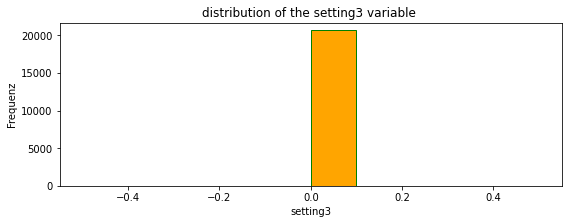

min s1 : 0.0 
max s1 : 0.0


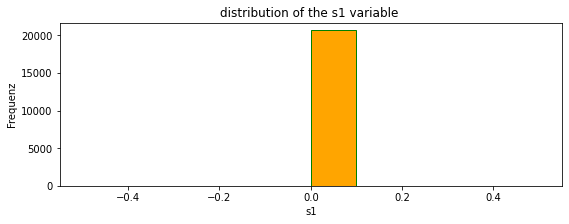

min s2 : 0.0 
max s2 : 1.0


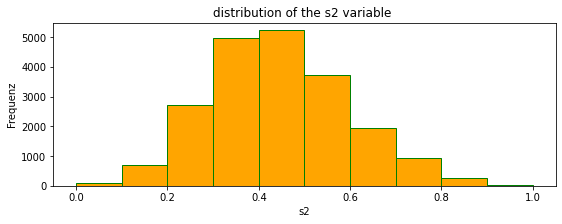

min s3 : 0.0 
max s3 : 1.0


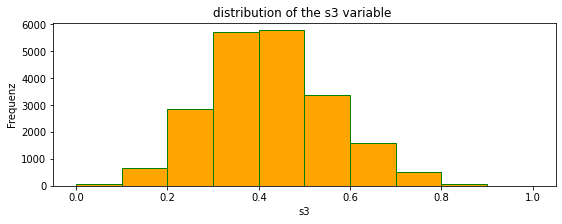

min s4 : 0.0 
max s4 : 1.0


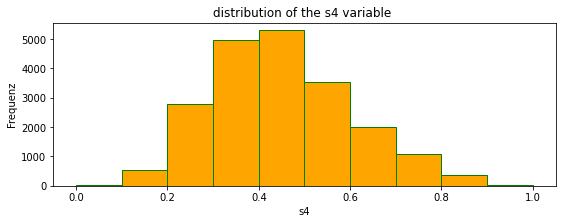

min s5 : 0.0 
max s5 : 0.0


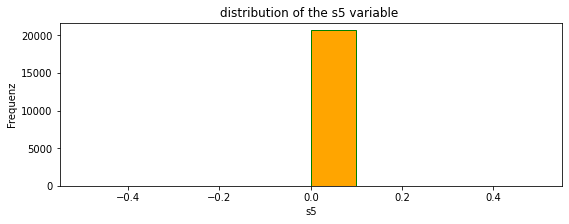

min s6 : 0.0 
max s6 : 1.0


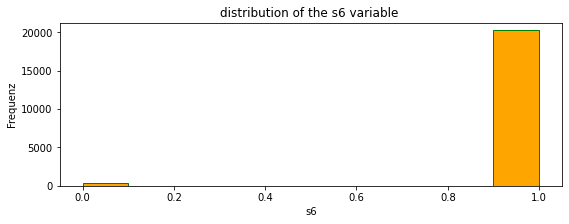

min s7 : 0.0 
max s7 : 1.0


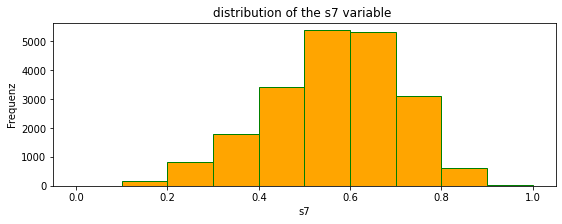

min s8 : 0.0 
max s8 : 1.0


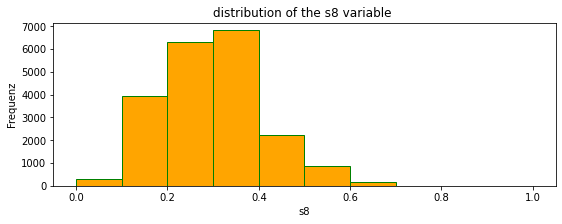

min s9 : 0.0 
max s9 : 1.0


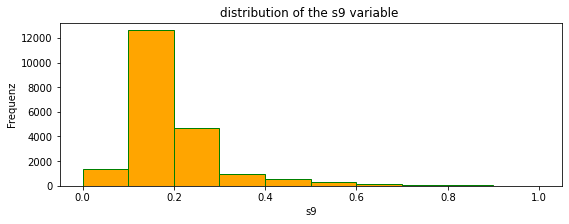

min s10 : 0.0 
max s10 : 0.0


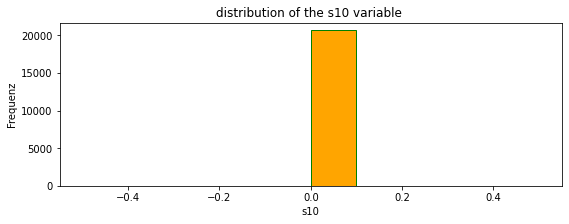

min s11 : 0.0 
max s11 : 1.0


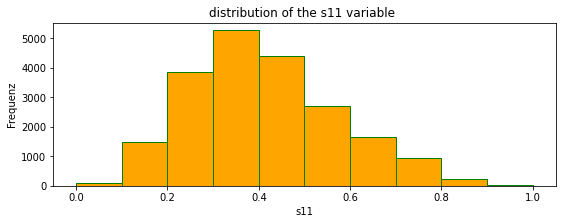

min s12 : 0.0 
max s12 : 1.0


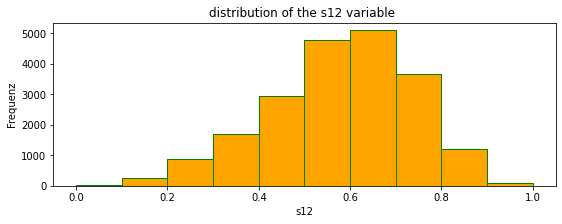

min s13 : 0.0 
max s13 : 1.0


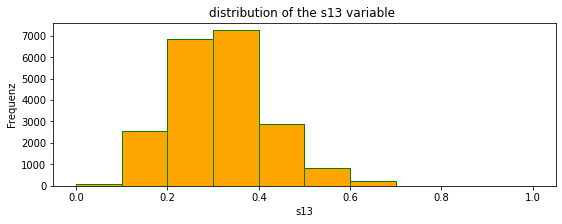

min s14 : 0.0 
max s14 : 1.0


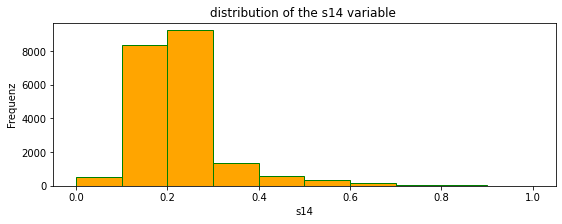

min s15 : 0.0 
max s15 : 1.0


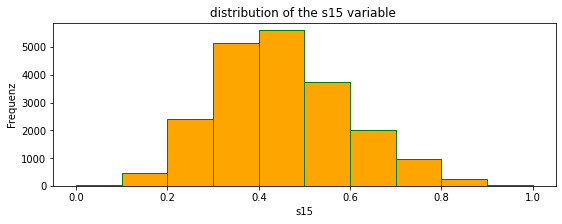

min s16 : 0.0 
max s16 : 0.0


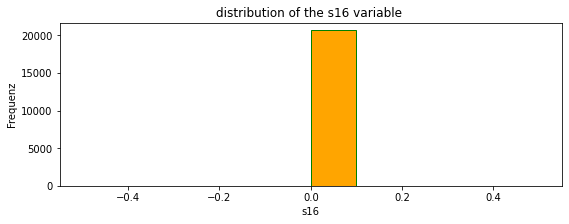

min s17 : 0.0 
max s17 : 1.0


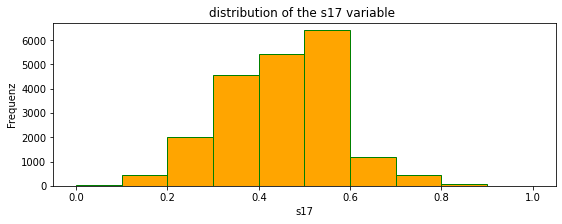

min s18 : 0.0 
max s18 : 0.0


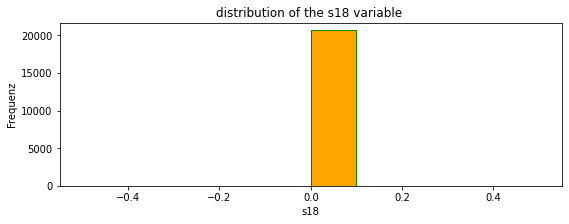

min s19 : 0.0 
max s19 : 0.0


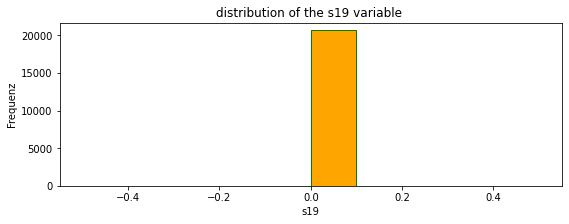

min s20 : 0.0 
max s20 : 1.0


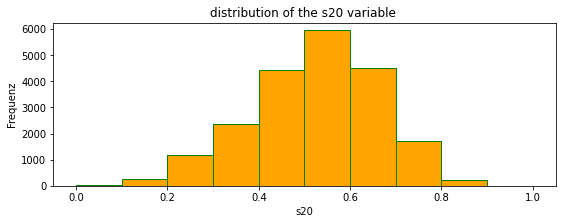

min s21 : 0.0 
max s21 : 1.0


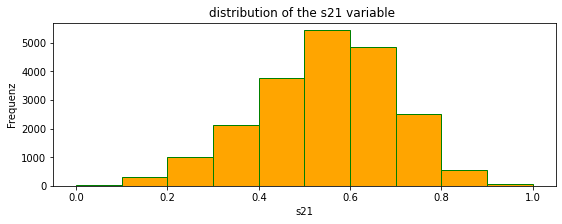

In [18]:
numericVar = ["zyklus", "setting1", "setting2","setting3", "s1", "s2", "s3", 
                    "s4", "s5", "s6", "s7", "s8", "s9", "s10", "s11", "s12",
                    "s13", "s14", "s15", "s16", "s17", "s18", "s19", "s20", "s21"]
for n in numericVar:
    plot_hist(n)

We see that some variables are just constants. These can be deleted as they do not contain any useful information about the state of the plant. The following columns are deleted: 'setting3', 's1', 's5', 's10', 's16 ', 's18', 's19'.

In [19]:
train_df.drop(columns=['setting3', 's1', 's5', 's10', 's16', 's18', 's19'],inplace=True)
test_df.drop(columns=['setting3', 's1', 's5', 's10', 's16', 's18', 's19'],inplace=True)
train_df2 = train_df
test_df2 = test_df



# 4. Modelling and Evaluation  

After the data has been prepared, the modeling can begin. We will build a Long Short-Term Memory Layer Recurrent Neural Network using the KERAS library. Keras requires a three-dimensional numpy array (inputs: A 3D tensor with shape [batch, timesteps, feature]), see also: https://keras.io/api/layers/recurrent_layers/lstm/ ). Therefore, in the next step, our features or variables are put into this three-dimensional shape.

At the same time the window size is defined, because LSTMs have the advantage to remember things from long sequences without a direct abstraction. 

Translated with www.DeepL.com/Translator (free version)

In [20]:
window_size = 25

def generate_sequenze(dataframe_id, laenge_sequenz, spalten_sequenz):

    array = dataframe_id[spalten_sequenz].values
    anzahl_elemente = array.shape[0]
    for start, stop in zip(range(0, anzahl_elemente-laenge_sequenz), range(laenge_sequenz, anzahl_elemente)):
        yield array[start:stop, :]

In [21]:
spalten_sensoren = ['s2', 's3','s4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21',]
spalten_sequenz = ['setting1', 'setting2', 'Zyklus normalisiert']
spalten_sequenz.extend(spalten_sensoren)


In [22]:
generierung_sequenz = (list(generate_sequenze(train_df2[train_df2['id']==id], window_size, spalten_sequenz)) 
           for id in train_df2['id'].unique())


In [23]:
array_sequenz = np.concatenate(list(generierung_sequenz)).astype(np.float32)
array_sequenz.shape

(18131, 25, 18)

In [24]:
def ueberschrift_generieren(dataframe_id, laenge_sequenz, ueberschrift):
    array_daten = dataframe_id[ueberschrift].values
    elemente_numerisch = array_daten.shape[0]
    return array_daten[laenge_sequenz:elemente_numerisch, :]

In [25]:
ueberschriften_generieren = [ueberschrift_generieren(train_df[train_df['id']==id], window_size, ['label1']) 
             for id in train_df2['id'].unique()]
ueb_array = np.concatenate(ueberschriften_generieren).astype(np.float32)
ueb_array.shape

(18131, 1)

In the next step, an LSTM network is created, since the data is now available in three-dimensional form. For this, the network is created with 100 units in the first step and a second one with 50 units. Dropout is used to avoid overfitting. Finally, a single layer, our output layer with a single unit and sigma activation, is generated, since there is a binary classification problem here.

In [26]:
spalten = array_sequenz.shape[2]
ausgabe = ueb_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(window_size, spalten),
         units=200,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=100,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=ausgabe, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [27]:
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25, 200)           175200    
_________________________________________________________________
dropout (Dropout)            (None, 25, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 295,701
Trainable params: 295,701
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
model.fit(array_sequenz, ueb_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1)

Epoch 1/10
87/87 [==============================] - 17s 151ms/step - loss: 0.2726 - accuracy: 0.8735 - val_loss: 0.1108 - val_accuracy: 0.9592
Epoch 2/10
87/87 [==============================] - 12s 136ms/step - loss: 0.0972 - accuracy: 0.9615 - val_loss: 0.0681 - val_accuracy: 0.9625
Epoch 3/10
87/87 [==============================] - 12s 144ms/step - loss: 0.0629 - accuracy: 0.9746 - val_loss: 0.1099 - val_accuracy: 0.9570
Epoch 4/10
87/87 [==============================] - 12s 132ms/step - loss: 0.0610 - accuracy: 0.9746 - val_loss: 0.0787 - val_accuracy: 0.9647
Epoch 5/10
87/87 [==============================] - 11s 130ms/step - loss: 0.0585 - accuracy: 0.9763 - val_loss: 0.0731 - val_accuracy: 0.9614
Epoch 6/10
87/87 [==============================] - 11s 130ms/step - loss: 0.0539 - accuracy: 0.9774 - val_loss: 0.0571 - val_accuracy: 0.9757
Epoch 7/10
87/87 [==============================] - 11s 126ms/step - loss: 0.0547 - accuracy: 0.9774 - val_loss: 0.0520 - val_accuracy: 0.9757

## 4.2. Evaluation

In [29]:
scores = model.evaluate(array_sequenz, ueb_array, verbose=1, batch_size=200)
print('accuracy: {}'.format(scores[1]))


91/91 [==============================] - 3s 35ms/step - loss: 0.0519 - accuracy: 0.9782
accuracy: 0.9782140851020813


In [30]:
y_pred = model.predict(array_sequenz,verbose=1, batch_size=200)
y_pred = np.round(y_pred).astype(int)
y_true = ueb_array
print('confusion Matrix')
konfusionsmatrix = confusion_matrix(y_true, y_pred)
konfusionsmatrix


91/91 [==============================] - 3s 30ms/step
confusion Matrix


array([[15698,   333],
       [   62,  2038]], dtype=int64)

In [31]:
accuracy = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'accuracy = ', accuracy, '\n', 'recall = ', recall)


accuracy =  0.859552931252636 
 recall =  0.9704761904761905


In the next step we will compare the test data, for this we have saved the last working state of the cycle for each fire detector in the test data. To be able to compare the results, we use the last sequence for each fire detector in the test data.

In [32]:
testdaten_vergleich = [test_df[test_df['id']==id][spalten_sequenz].values[ - window_size:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= window_size]

testdaten_vergleich = np.asarray(testdaten_vergleich).astype(np.float32)
testdaten_vergleich.shape

(100, 25, 18)

In [33]:
y2 = [len(test_df[test_df['id']==id]) >= window_size for id in test_df['id'].unique()]


In [34]:
ueb_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y2].values
ueb_array_test_last = ueb_array_test_last.reshape(ueb_array_test_last.shape[0],1).astype(np.float32)
ueb_array_test_last.shape


(100, 1)

In [35]:
print(testdaten_vergleich.shape)
print(ueb_array_test_last.shape)


(100, 25, 18)
(100, 1)


In [36]:
werte_testdaten = model.evaluate(testdaten_vergleich, ueb_array_test_last, verbose=2)
print('accuracy: {}'.format(werte_testdaten[1]))


4/4 - 0s - loss: 0.1298 - accuracy: 0.9400
accuracy: 0.9399999976158142


In [37]:
testdaten_y = model.predict(testdaten_vergleich)
testdaten_y = np.round(testdaten_y).astype(int)
wahrheit_y = ueb_array_test_last
print('confusion Matrix')
konfusionsmatrix2 = confusion_matrix(wahrheit_y, testdaten_y)
konfusionsmatrix2


confusion Matrix


array([[80,  4],
       [ 2, 14]], dtype=int64)

In [42]:
testdaten_genauigkeit = precision_score(wahrheit_y, testdaten_y)
recall_test = recall_score(wahrheit_y, testdaten_y)
f1_test = 2 * (testdaten_genauigkeit * recall_test) / (testdaten_genauigkeit + recall_test)
print( 'Precision: ', testdaten_genauigkeit, '\n', 'recall: ', recall_test,'\n', 'F1-score:', f1_test )


Precision:  0.7777777777777778 
 recall:  0.875 
 F1-score: 0.823529411764706


In [43]:
results_df = pd.DataFrame([[werte_testdaten[1],testdaten_genauigkeit,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM'])
results_df


,Accuracy,Precision,Recall,F1-score
LSTM,0.94,0.777778,0.875,0.823529
